In [1]:
# 数据集中彩色的掩码，按照colors.json中给出的编号，替换为classid写入到单通道掩码图片中
import os
import cv2
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

h, w = 1024, 1280

In [2]:
with open("colors.json", "r") as f:
    label_list = json.load(f)
# label_list = label_list[:8]
label_list

[{'name': 'background-tissue', 'color': [0, 0, 0], 'classid': 0},
 {'name': 'instrument-shaft', 'color': [0, 255, 0], 'classid': 1},
 {'name': 'instrument-clasper', 'color': [0, 255, 255], 'classid': 2},
 {'name': 'instrument-wrist', 'color': [125, 255, 12], 'classid': 3},
 {'name': 'kidney-parenchyma', 'color': [255, 55, 0], 'classid': 4},
 {'name': 'covered-kidney', 'color': [24, 55, 125], 'classid': 5},
 {'name': 'thread', 'color': [187, 155, 25], 'classid': 6},
 {'name': 'clamps', 'color': [0, 255, 125], 'classid': 7},
 {'name': 'suturing-needle', 'color': [255, 255, 125], 'classid': 8},
 {'name': 'suction-instrument', 'color': [123, 15, 175], 'classid': 9},
 {'name': 'small-intestine', 'color': [124, 155, 5], 'classid': 10},
 {'name': 'ultrasound-probe', 'color': [12, 255, 141], 'classid': 11}]

In [6]:
# 彩色掩码生成灰度掩码，用类号替代颜色
h = 512
w = 512
output_dir = '/home/duhj/datasets/davinci/test/label/'
!mkdir -p $output_dir
for id in range(1, 17):    
    data_dir = '/home/duhj/datasets/miccai_2018/test_data/seq_' + str(id) +'/labels/'
    files = glob.iglob(data_dir+'/*.png')  
    # count = 0
    for f in files:
        image = cv2.imread(f, cv2.)
        image = cv2.resize(image, (w, h), cv2.INTER_CUBIC)  # type: ignore cv2的w在h前
        # 背景白色
        mask = np.zeros([h, w, 1], np.uint8)
        threshold = 10  # 差值小于阈值的像素将被替换
        for i in range(1, len(label_list)):
            # 要替换的颜色
            target_color = np.array(label_list[i]['color']) 
            # 计算每个像素与目标颜色的差值
            color_difference = np.abs(image - target_color)
            # 计算差值的总和（BGR通道之和）
            color_difference_sum = np.sum(color_difference, axis=2)
            # 找到需要替换的像素索引
            replace_indices = np.where(color_difference_sum < threshold)
            # 将需要替换的像素值设置为掩码类别编号
            mask[replace_indices] = label_list[i]['classid']
        save_name = output_dir + 'seq_' + str(id) + '_' + f[-12:-4] +'.bmp'
        cv2.imwrite(save_name, mask)
        print("{}".format(save_name), end='\r')
        # count += 1


In [8]:
# 检查某张mask图像中，不同颜色掩码生成的不同数值的个数
checkimage = cv2.imread('/home/duhj/datasets/davinci/test/label/seq_4_frame000.bmp', cv2.IMREAD_GRAYSCALE)

for k in range(12):
    count = 0
    for i in range(checkimage.shape[0]):
        for j in range(checkimage.shape[1]):
            # if checkimage[i][j] ==mask_list[k]['classid']:
            if checkimage[i][j] ==k:
                count+=1
    print(k, count)

0 157394
1 0
2 0
3 0
4 5952
5 40630
6 0
7 0
8 0
9 0
10 58168
11 0


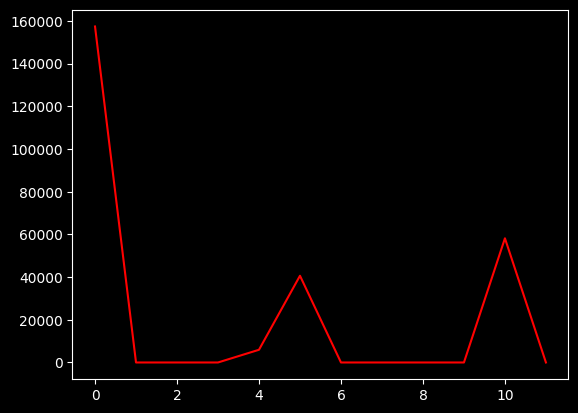

In [58]:
# 检查某张mask图像中，不同颜色掩码生成的不同数值的个数
img = cv2.imread('/home/duhj/datasets/davinci/val/label/seq_4_frame000.bmp', cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([img], [0], None, [12], [0, 11])
plt.plot(hist, color="r")
plt.savefig("result_gray.jpg")


In [59]:
hist

array([[157394.],
       [     0.],
       [     0.],
       [     0.],
       [  5952.],
       [ 40630.],
       [     0.],
       [     0.],
       [     0.],
       [     0.],
       [ 58168.],
       [     0.]], dtype=float32)

In [41]:
# 训练掩码图中，包括0在内的所有像素的值，计总数，最后的到所有类别的占比，求出各类的权重
data_dir = '/home/duhj/datasets/davinci/train/label/'
files = glob.iglob(data_dir+'*.bmp')
pics = 0
counts = None
num_classes = len(label_list)
for f in files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [num_classes ], [0, num_classes ])
    if counts is None:
        counts = hist
    else:
        counts += hist
    # print(str(f), end='\r')
    pics += 1
print(counts)
print(pics)

[[2.68503616e+08]
 [5.27019200e+07]
 [2.67339540e+07]
 [1.22873590e+07]
 [1.00093464e+08]
 [6.79929680e+07]
 [1.89401100e+06]
 [2.83949800e+06]
 [1.43130000e+04]
 [2.38166300e+06]
 [4.74282400e+07]
 [3.02070600e+06]]
2235


In [50]:
counts = counts[[1, 2, 3, 4, 6, 7, 8, 10, 11],0]

In [51]:
normedWeights = [1 - (x / sum(counts)) for x in counts]
normedWeights

[0.7866435337846867,
 0.8917712684205292,
 0.9502563190229326,
 0.5947853935816818,
 0.9923323572664349,
 0.9885046833378092,
 0.9999420557903594,
 0.8079933010939302,
 0.987771087701636]

In [9]:
# all = counts.sum()
# weights = counts/all
# weights = 1/weights


x = []
for i in range(len(normedWeights)):
    x.append(normedWeights[i][0])
x

[0.541718,
 0.91004837,
 0.9543705,
 0.9790279,
 0.82916045,
 0.8839496,
 0.9967673,
 0.99515355,
 0.99997556,
 0.99593496,
 0.9190495,
 0.99484426]

In [ ]:
# 训练掩码图中，包括0在内的所有像素的值，计总数，最后的到所有类别的占比，求出各类的权重
data_dir = '/home/duhj/datasets/davinci/val/label/'
files = glob.iglob(data_dir+'*.bmp')
pics = 0
counts = [0] *12
for f in files:
    image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            for k in range(12):
                if checkimage[i][j] == k:
                    counts[k] += 1
    print(str(f), end='\r')
    pics += 1
print(counts)
print(pics)
    

In [15]:
# 查看实际共有多少类别
data_dir = '256/mask'
files = glob.iglob(data_dir+'/*.png')
max = 0
for f in files:
    for k in range(1, len(label_list)):
        
        count = 0
        for i in range(checkimage.shape[0]):
            for j in range(checkimage.shape[1]):
                if checkimage[i][j] ==label_list[k]['classid']:
                    count+=1
                    if label_list[k]['classid'] > max:
                        max = label_list[k]['classid']
                        break
print(max)

5


In [2]:
# 把all_data下所有子目录中的图像汇总到out_images
for id in range(1, 17):
    
    data_dir = '/home/duhj/datasets/miccai_2018/seq_' + str(id) +'/left_frames/'
    files = glob.iglob(data_dir+'/*.png')

    for f in files:
        save_name = '/home/duhj/datasets/davinci_1/image/seq_'+str(id)+'_' + f[-12:-4] +'.png'
        !cp $f $save_name

In [4]:
# 把all_data下所有子目录中的图像缩放后汇总到out_images
output_dir = '/home/duhj/datasets/davinci/train/image/'
!mkdir -p $output_dir
for id in range(1, 17):
    data_dir = '/home/duhj/datasets/miccai_2018/train_data/seq_' + str(id) +'/left_frames/'
    files = glob.iglob(data_dir+'/*.png')
    count =0
    for filename in files:
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (w, h), cv2.INTER_CUBIC)  # type: ignore
        savename = output_dir + 'seq_'+str(id)+'_' + filename[-12:-4]+'.bmp'
        cv2.imwrite(savename, img)
        print(filename, end='\r')
        count += 1
        if count == 22:
            break
    